In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import BertModel, BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
import math
import torch
from transformers import TrainingArguments, Trainer

In [11]:
# 데이터 로드
data = pd.read_csv('감정데이터_v3.csv')
data = data.sample(frac=0.01)

# 먼저 데이터를 train과 test로 나눕니다.
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)

# 그 후, 남은 데이터를 다시 validation과 test로 나눕니다.
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# 각 데이터셋의 크기를 확인합니다.
train_data.shape, validation_data.shape, test_data.shape

((877, 4), (188, 4), (188, 4))

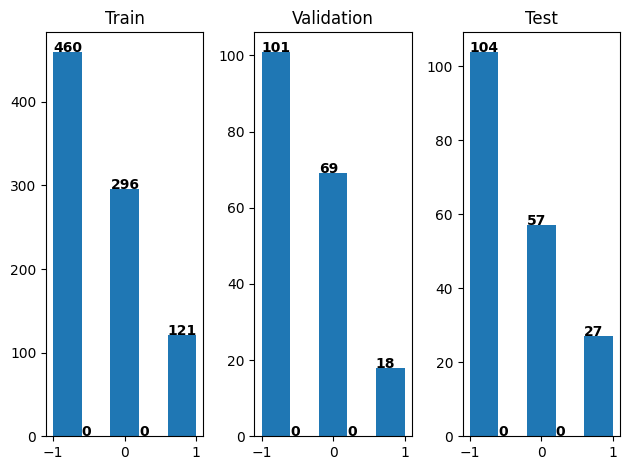

In [12]:
fig, axs = plt.subplots(1, 3, tight_layout=True)
distributions = []

axs[0].set_title("Train"); axs[1].set_title("Validation"); axs[2].set_title("Test"); 
train_distributions = axs[0].hist(train_data["valence"], bins=5)
val_distributions = axs[1].hist(validation_data["valence"], bins=5)
test_distributions = axs[2].hist(test_data["valence"], bins=5)

for distributions, ax in zip([train_distributions, val_distributions, test_distributions], axs):
    for j in range(5):
        # Display the counts on each column of the histograms
        ax.text(distributions[1][j], distributions[0][j], str(int(distributions[0][j])), weight="bold")


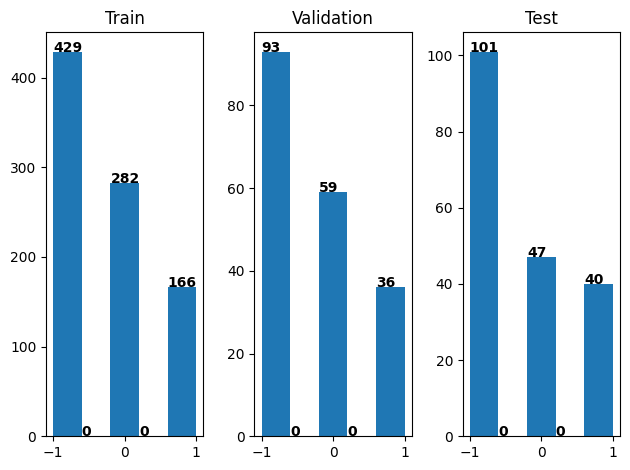

In [13]:
fig, axs = plt.subplots(1, 3, tight_layout=True)
distributions = []

axs[0].set_title("Train"); axs[1].set_title("Validation"); axs[2].set_title("Test"); 
train_distributions = axs[0].hist(train_data["arousal"], bins=5)
val_distributions = axs[1].hist(validation_data["arousal"], bins=5)
test_distributions = axs[2].hist(test_data["arousal"], bins=5)

for distributions, ax in zip([train_distributions, val_distributions, test_distributions], axs):
    for j in range(5):
        # Display the counts on each column of the histograms
        ax.text(distributions[1][j], distributions[0][j], str(int(distributions[0][j])), weight="bold")


In [14]:
BASE_MODEL = "./kobert"
LEARNING_RATE = 2e-5
MAX_LENGTH = 64
BATCH_SIZE = 16
EPOCHS = 20

tokenizer = BertTokenizer.from_pretrained(BASE_MODEL)
model = BertForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
ds = {"train": train_data, "validation": validation_data, "test": test_data}

def preprocess_function(examples):
    label = examples["valence"] 
    examples = tokenizer(examples["sentence"], truncation=True, padding="max_length", max_length=MAX_LENGTH)
    
    # Change this to real number
    examples["label"] = float(label)
    return examples

for split in ds:
    # 데이터 전처리 적용
    ds[split] = ds[split].apply(preprocess_function, axis=1)
    
    # 불필요한 열 제거
    ds[split] = ds[split].drop(columns=["sentence", "valence", "arousal"])

In [18]:
def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)
    
    mse = mean_squared_error(labels, logits)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)
    single_squared_errors = ((logits - labels).flatten()**2).tolist()
    
    # Compute accuracy 
    # Based on the fact that the rounded score = true score only if |single_squared_errors| < 0.5
    accuracy = sum([1 for e in single_squared_errors if e < 0.25]) / len(single_squared_errors)
    
    return {"mse": mse, "mae": mae, "r2": r2, "accuracy": accuracy}

In [30]:
training_args = TrainingArguments(
    output_dir="kobert-regression-2",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
    weight_decay=0.01,
)

c:\Users\user\Desktop\.venv\lib\site-packages\transformers\training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`

In [27]:
class RegressionTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs[0][:, 0]
        loss = torch.nn.functional.mse_loss(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [31]:
trainer = RegressionTrainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    compute_metrics=compute_metrics_for_regression,
)

trainer.train()

NameError: name 'training_args' is not defined

In [ ]:

trainer.eval_dataset=ds["test"]
trainer.evaluate()

In [ ]:
nb_batches = math.ceil(len(data)/BATCH_SIZE)
y_preds = []

for i in range(nb_batches):
    input_texts = data[i * BATCH_SIZE: (i+1) * BATCH_SIZE]["sentence"]
    input_labels = data[i * BATCH_SIZE: (i+1) * BATCH_SIZE]["valence"]
    encoded = tokenizer(input_texts, truncation=True, padding="max_length", max_length=64, return_tensors="pt").to("cuda")
    y_preds += model(**encoded).logits.reshape(-1).tolist()

pd.set_option('display.max_rows', 500)
df = pd.DataFrame([data["sentence"], data["valence"], y_preds], ["sentence", "valence", "Prediction"]).T
df["Rounded Prediction"] = df["Prediction"].apply(round)
incorrect_cases = df[df["valecnce"] != df["Rounded Prediction"]]
incorrect_cases

In [ ]:
confusion_matrix(df["Score"].tolist(), df["Rounded Prediction"].tolist())